In [0]:
'''
Group 3: Yu Qiao (Team lead), Yunzhi Yu, Chuyun Huang
Our team used Kaggleslayer's Grocery prediction with Neural Network as reference for data loading and cleaning.
We designed our own machine learning model application and testing

'''
import pandas as pd
import numpy as np
import datetime
from datetime import date,timedelta

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from scipy.stats import itemfreq
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

### Load data

In [0]:
#define datatype
changetype = {'store_nbr': np.dtype('int64'),
              'unit_sales': np.dtype('float64'),
              'item_nbr': np.dtype('int64'),
              'onpromotion': np.dtype('O')}
#load all csv datasets
train = pd.read_csv('train.csv', dtype=changetype)
testdata = pd.read_csv('test.csv', dtype=changetype)
stores = pd.read_csv('stores.csv')
oils = pd.read_csv('oil.csv')
items = pd.read_csv('items.csv')
trans = pd.read_csv('transactions.csv')
holidays = pd.read_csv('holidays_events.csv')

In [0]:
#select part of the train dataset through date
train_data = train[(train['date'] <= '2017-08-15') & (train['date'] >= '2017-06-15')]

#rename column name in oils dataset
oils = oils.rename(columns={"dcoilwtico": "oilprice"})

#take a look at the first five rows of oils dataset
oils.head(5)

,date,oilprice
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


### Oil Visulization and data cleaning

In [0]:
#find start and end date in train_data
start_date, end_date = min(train_data.date), max(train_data.date)
start = datetime.datetime.strptime(start_date, '%Y-%m-%d') 
end = datetime.datetime.strptime(end_date, '%Y-%m-%d') 
#calculate the length of time frame
time_frame = end - start

# find every single date within the time frame and put them into a list
date_list = []
for day in range(time_frame.days + 1): 
    date_list.append(datetime.date.strftime(start + timedelta(days = day), '%Y-%m-%d'))

#trun the date_list into a dataframe
date_list = pd.DataFrame({'date': date_list}) 

#merge pd_date with oils according to the date column in pd_date
oil = date_list.merge(oils, left_on='date', right_on='date', how='left')

#take a look at the number of NA value in oil
number_NA = oil['oilprice'].isnull().sum()
print('Number of NA value in oil: ', '\n', number_NA)

Number of NA value in oil:  
 20


In [0]:
na_oil = oil[oil['oilprice'].isnull() == True].index.values #find out the index of each of the missing data
oil_add = na_oil.copy() #make a copy of the missing data index
oil_minus = np.maximum(0, na_oil-1) #make an array stores each date's previous date

#make oil_add store each date's following date
i = 0
while i != number_NA:
    j = 1
    while (na_oil[min(i+j,number_NA-1)] == na_oil[i]+j):
        j += 1
    oil_add[i] = min(len(oil)-1, oil_add[i] + j )
    i += 1

# fill the missing oil price by taking the average of the previous and the following dates' oil prices
i = 0
while i != number_NA:
    if (na_oil[i] == 0):
        oil.loc[na_oil[i], 'oilprice'] = oil.loc[oil_add[i], 'oilprice']
    elif (na_oil[i] == len(oil)):
        oil.loc[na_oil[i], 'oilprice'] = oil.loc[oil_minus[i], 'oilprice']
    else:
        oil.loc[na_oil[i], 'oilprice'] = (oil.loc[oil_add[i], 'oilprice'] + oil.loc[oil_minus[i], 'oilprice'])/ 2
    i += 1
  

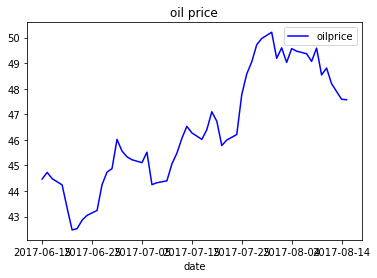

In [0]:
#draw a line chart showing oil price
oil.plot(kind='line', title= 'oil price', x='date',y='oilprice',color='blue')
plt.show()

## Merge

In [0]:
#merge all data sets with train_data one by one
train_data = train_data.drop('id', axis = 1)
train_data = train_data.merge(stores, left_on='store_nbr', right_on='store_nbr', how='left')
train_data = train_data.merge(items, left_on='item_nbr', right_on='item_nbr', how='left')
train_data = train_data.merge(holidays, left_on='date', right_on='date', how='left')
train_data = train_data.merge(oil, left_on='date', right_on='date', how='left')
train_data = train_data.drop(['description', 'state', 'locale_name', 'class'], axis = 1)

# Find the top N purchased item

In [0]:
def Most_Purchased(data, item, N):  # obtain the most N purshased item
    freq = itemfreq(data[item])
    freq = freq[freq[:, 1].argsort()[::-1]] 
    main_labels = freq[:,0][0:N]
        
    all_labels = data[item].to_numpy()
    all_labels = all_labels.reshape(all_labels.shape[0],1)

    filtered = np.where(all_labels == main_labels)
    
    return freq, filtered

label_freq, filtered = Most_Purchased(train_data, "item_nbr", 12)

filtered_train = train_data.loc[filtered[0],:]
print("The filterd shape is ", filtered_train.shape)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  


The filterd shape is  (41843, 14)


### Replace N/A

In [0]:
na_index_pd_train = filtered_train[filtered_train['type_y'].isnull() == True].index.values

filtered_train.loc[filtered_train['locale'].isnull(), 'locale'] = "normal day"
filtered_train.loc[filtered_train['type_y'].isnull(), 'type_y'] = "normal day"
filtered_train.loc[filtered_train['transferred'].isnull(), 'transferred'] = "normal day"


### Reformat

In [0]:
def reformat_date(train): 
    dates = [ 'year', 'month']
    for i in range(2):
        train[dates[i]] = train.date.apply(lambda x: x.split('-')[i])
    train['date'] = pd.to_datetime(train['date'])
    train['day'] = train['date'].dt.day_name()  
    train = train.drop('date', axis = 1)
    return train

filtered_train =reformat_date(filtered_train)
filtered_train

,store_nbr,item_nbr,unit_sales,onpromotion,city,type_x,cluster,family,perishable,type_y,locale,transferred,oilprice,year,month,day
111,1,222879,7.0,False,Quito,D,13,GROCERY I,0,normal day,normal day,normal day,44.47,2017,06,Thursday
146,1,265559,22.0,False,Quito,D,13,GROCERY I,0,normal day,normal day,normal day,44.47,2017,06,Thursday
180,1,314384,13.0,False,Quito,D,13,GROCERY I,0,normal day,normal day,normal day,44.47,2017,06,Thursday
205,1,323013,6.0,False,Quito,D,13,GROCERY I,0,normal day,normal day,normal day,44.47,2017,06,Thursday
230,1,364606,45.0,False,Quito,D,13,GROCERY I,0,normal day,normal day,normal day,44.47,2017,06,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6861814,54,1162382,20.0,False,El Carmen,C,3,GROCERY I,0,Holiday,Local,False,47.57,2017,08,Tuesday
6862004,54,1418845,10.0,False,El Carmen,C,3,GROCERY I,0,Holiday,Local,False,47.57,2017,08,Tuesday
6862276,54,1958216,15.0,False,El Carmen,C,3,BEVERAGES,0,Holiday,Local,False,47.57,2017,08,Tuesday
6862430,54,2042941,10.0,False,El Carmen,C,3,BEVERAGES,0,Holiday,Local,False,47.57,2017,08,Tuesday


In [0]:
filtered_train = filtered_train.rename(columns={"type_x": "store_type", "type_y": "holiday"})

### Dummy Variables

In [0]:
dum_var = ['onpromotion','city','store_type','cluster','store_nbr','item_nbr',
                'family','perishable','holiday', 'locale', 'transferred', 'month', 'day']

for i in dum_var:
    dummy = pd.get_dummies(filtered_train[i], prefix = i)
    filtered_train = pd.concat([filtered_train, dummy], axis = 1)
    
filtered_train = filtered_train.drop(dum_var, axis = 1)
filtered_train = filtered_train.drop(['year'], axis = 1)

### Normilization and Scale

In [0]:
for i in ['unit_sales','oilprice']:
    minimum, maxi = filtered_train[i].min(), filtered_train[i].max()
    filtered_train.loc[:,i] = (filtered_train[i] - minimum) / (maxi - minimum)

### Split into Training and Testing Sets

In [0]:
filtered_train = filtered_train.reset_index(drop=True)
y = filtered_train['unit_sales']
x = filtered_train.drop(['unit_sales'], axis = 1)

# We split 80$ of data from training
X_train, X_validation, y_train, y_validation = train_test_split(x, y, test_size=0.2, random_state=11)

### LinearRegression

In [0]:
from sklearn.linear_model import LinearRegression

# Train the Estimator / model
linear_regression = LinearRegression()
linear_regression.fit(X= X_train, y = y_train)
# print(len(linear_regression.coef_))
# print(f'Regression Coefficient (slopt) = {linear_regression.coef_}')
# print(f'Intercept = {linear_regression.intercept_}')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
predicted = linear_regression.predict(X_validation)
expected = y_validation

from sklearn import metrics

r2 = metrics.r2_score(expected, predicted)
mse = metrics.mean_squared_error(expected, predicted)
print(f'R2 score = {r2}')
print(f'MSE score = {mse}')

R2 score = 0.4225244018075951
MSE score = 0.0005829960485230031


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

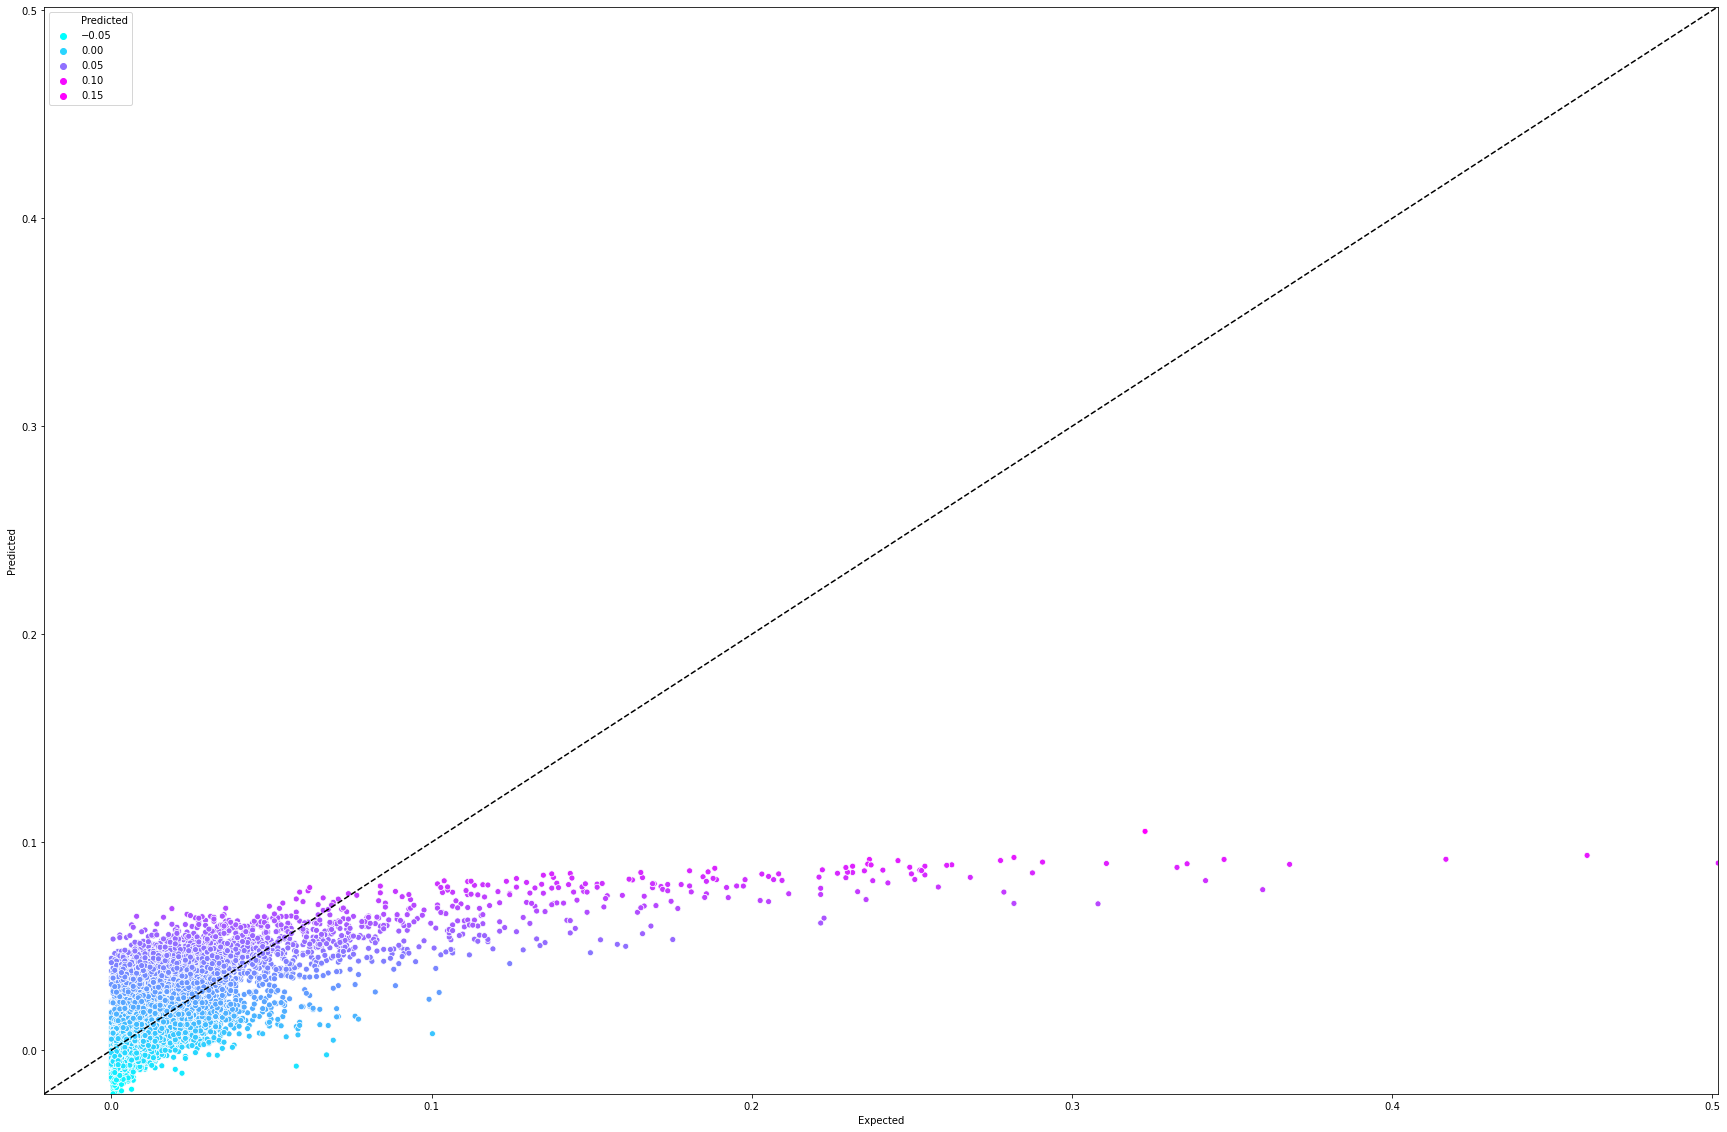

In [0]:
data = {'Expected': expected, 'Predicted': predicted}

df = pd.DataFrame(data)
# df['Expected'] = pd.Series(expected)
# df['Predicted'] = pd.Sereis(predicted)
fiure = plt.figure(figsize = (30, 20))

axes = sns.scatterplot(data = df, x = 'Expected', y = 'Predicted', hue = 'Predicted', palette = 'cool')
start = min(expected.min(), predicted.min())
end = max(expected.max(), predicted.max())
axes.set_xlim(start, end)
axes.set_ylim(start, end)

line = plt.plot([start, end], [start, end], 'k--')
plt.plot

### Random Forest

In [0]:
RFR = RandomForestRegressor()

parameters = {'n_estimators': [6, 12, 48],
              'max_depth':[6, 12, 20],
            'min_samples_leaf': [1,5],
            }

grid_obj = GridSearchCV(RFR, parameters, cv=7, n_jobs=-1, verbose=1)
grid_obj = grid_obj.fit(X_train, y_train)

RFR = grid_obj.best_estimator_

RFR.fit(X_train, y_train)

Fitting 7 folds for each of 18 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:  1.8min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=48, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
pred = RFR.predict(X_validation)

y_val = y_validation

print('R2 score = ',r2_score(y_val, pred))
print('MSE score = ',mean_squared_error(y_val, pred))

R2 score =  0.8707959474382174
MSE score =  0.00013043919488972162


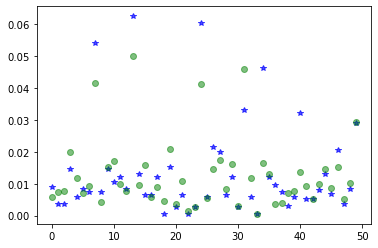

In [0]:
plt.plot(y_val.to_numpy()[0:50], '*', color ='blue', alpha=0.7)
plt.plot(pred[0:50], 'ro', color ='green', alpha=0.5)
plt.show()


### Neural Network using Tensorflow




In [0]:
# Idea adopted from a youTube Channel called "sentdex"
# Link: https://www.youtube.com/watch?v=wQ8BIBpya2k
import tensorflow as tf
tf.__version__

'2.1.0'

In [0]:
features = np.array(X_train)
targets = np.array(y_train.values.reshape(y_train.shape[0],1))
features_validation= np.array(X_validation)
targets_validation = np.array(y_validation.values.reshape(y_validation.shape[0],1))

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu))
model.add(tf.keras.layers.Dropout(.2))
model.add(tf.keras.layers.Dense(64, activation = tf.nn.relu))
model.add(tf.keras.layers.Dropout(.1))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

#can also add stocstic gradient descent
model.fit(features, targets, epochs = 5)

Train on 33474 samples
Epoch 1/5
33474/33474 [==============================] - 3s 103us/sample - loss: 0.0024 - mse: 0.0024
Epoch 2/5
33474/33474 [==============================] - 2s 57us/sample - loss: 3.8811e-04 - mse: 3.8811e-04
Epoch 3/5
33474/33474 [==============================] - 2s 57us/sample - loss: 2.8435e-04 - mse: 2.8435e-04
Epoch 4/5
33474/33474 [==============================] - 2s 58us/sample - loss: 2.7330e-04 - mse: 2.7330e-04
Epoch 5/5
33474/33474 [==============================] - 2s 58us/sample - loss: 2.3401e-04 - mse: 2.3401e-04


In [0]:
#validation lost
# Returns the loss value & metrics values for the model in test mode.
val_loss, mse = model.evaluate(features_validation, targets_validation)
print(val_loss, mse)

8369/8369 [==============================] - 0s 23us/sample - loss: 1.4872e-04 - mse: 1.4872e-04
0.00014871683256193787 0.00014871688


In [0]:
predictions = model.predict(features_validation, verbose=0)

print('R2 score = ',r2_score(y_validation, predictions))
print('MSE score = ',mse)

R2 score =  0.8526913862110339
MSE score =  0.00014871688


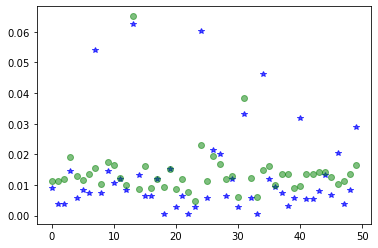

In [0]:
plt.plot(targets_validation[0:50], '*', color ='blue', alpha=0.7)
plt.plot(predictions[0:50], 'ro', color ='green', alpha=0.5)
plt.show()